In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

# Lending Club Data Explorations

## Preprocess Data

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.externals import joblib

# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")  

In [4]:
def get_item_description(label):
    """
    Print the description for an item label based on the data dictionary
    """
    print(df_data_dictionary[df_data_dictionary.Item == label].Description.values[0])

In [5]:
import datetime
import calendar

def convert_date_months(col):
    """
    Convert the date to difference from this month
    
    Attributes
    ------------
    col: pandas series
    """
    today = datetime.date.today()
    tmp_2 = pd.to_datetime(col)
    tmp_2 = today - tmp_2
    tmp_2 = tmp_2.astype('timedelta64[M]').astype(int)
    
    return tmp_2

def convert_date_days(col):
    """
    Convert the date to difference from this day
    
    Attributes
    ------------
    col: pandas series
    """
    today = datetime.date.today()
    tmp_2 = pd.to_datetime(col)
    tmp_2 = today - tmp_2
    tmp_2 = tmp_2.astype('timedelta64[D]').astype(int)
    
    return tmp_2


def convert_num_day_of_week(x):
    """
    Convert the date to numeric day of the week
    
    Attributes
    ------------
    x: datetime obj
    """
    my_date = pd.to_datetime(x) 
    return my_date.weekday()

def convert_day_of_week(x):
    """
    Convert the date to string day of the week
    
    Attributes
    ------------
    x: datetime obj
    """
    my_date = pd.to_datetime(x) 
    return calendar.day_name[my_date.weekday()]

def convert_week_of_year(x):
    """
    Convert the date to the week of the year
    
    Attributes
    ------------
    x: datetime obj
    """
    my_date = pd.to_datetime(x) 
    return my_date.isocalendar()[1]

In [6]:
import operator

def find_missing_values(df):
    """
    df: pandas dataframe

    Returns sorted list of features by the percentage missing values
    """
    count_nan = (len(df) - df.count()) / len(df)
    percentage_nan = {}

    for item in range (0, len(count_nan)):
        if count_nan[item] > 0:
            percentage_nan[count_nan.index[item]] = round(count_nan[item], 4)
    
    return sorted(percentage_nan.items(), key=operator.itemgetter(1))

In [7]:
def get_var_type(df):
    """
    Automatically determine variable type
    Attribute:
    ------------
    df: pandas dataframe
    """
    
    continuous_vars = []
    rest = []
    for cols in df.columns:
        a = type(df.ix[0, cols])== np.float64 and pd.notnull(df.ix[0, cols])
        b = type(df.ix[0, cols])== float and pd.notnull(df.ix[0, cols])
        if (a) or (b):
            continuous_vars.append(cols)
        else:
            rest.append(cols)
            
    return (continuous_vars, rest)

## Load Data

In [2]:
dataPath = 'data'
df = pd.read_csv(dataPath+'/LoanStats3a.csv')
df_b = pd.read_csv(dataPath+'/LoanStats3b.csv')
df_c = pd.read_csv(dataPath+'/LoanStats3c.csv')

df = df.append(df_b)
df = df.append(df_c)
df = df.reset_index()
print ("Dataset has {} samples with {} features each.".format(*df.shape))


Dataset has 379058 samples with 97 features each.


Load data dictionary

In [9]:
xls_file = pd.ExcelFile(dataPath+'/LCDataDictionary.xlsx')
xls_file.sheet_names

[u'LoanStats', u'browseNotes', u'RejectStats']

In [10]:
df_data_dictionary = xls_file.parse('LoanStats')
df_data_dictionary.columns = [u'Item', u'Description']
df_ = xls_file.parse('browseNotes')
df_.columns = df_data_dictionary.columns
df_data_dictionary = df_data_dictionary.append(df_)

In [11]:
df_data_dictionary.head()

,Item,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,accept_d,The date which the borrower accepted the offer
3,addr_city,The city provided by the borrower in the loan...
4,addr_state,The state provided by the borrower in the loan...


In [12]:
df.head()

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,policy_code
0,0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


The first thing I am going to do is find the percentage of missing values in my dataset

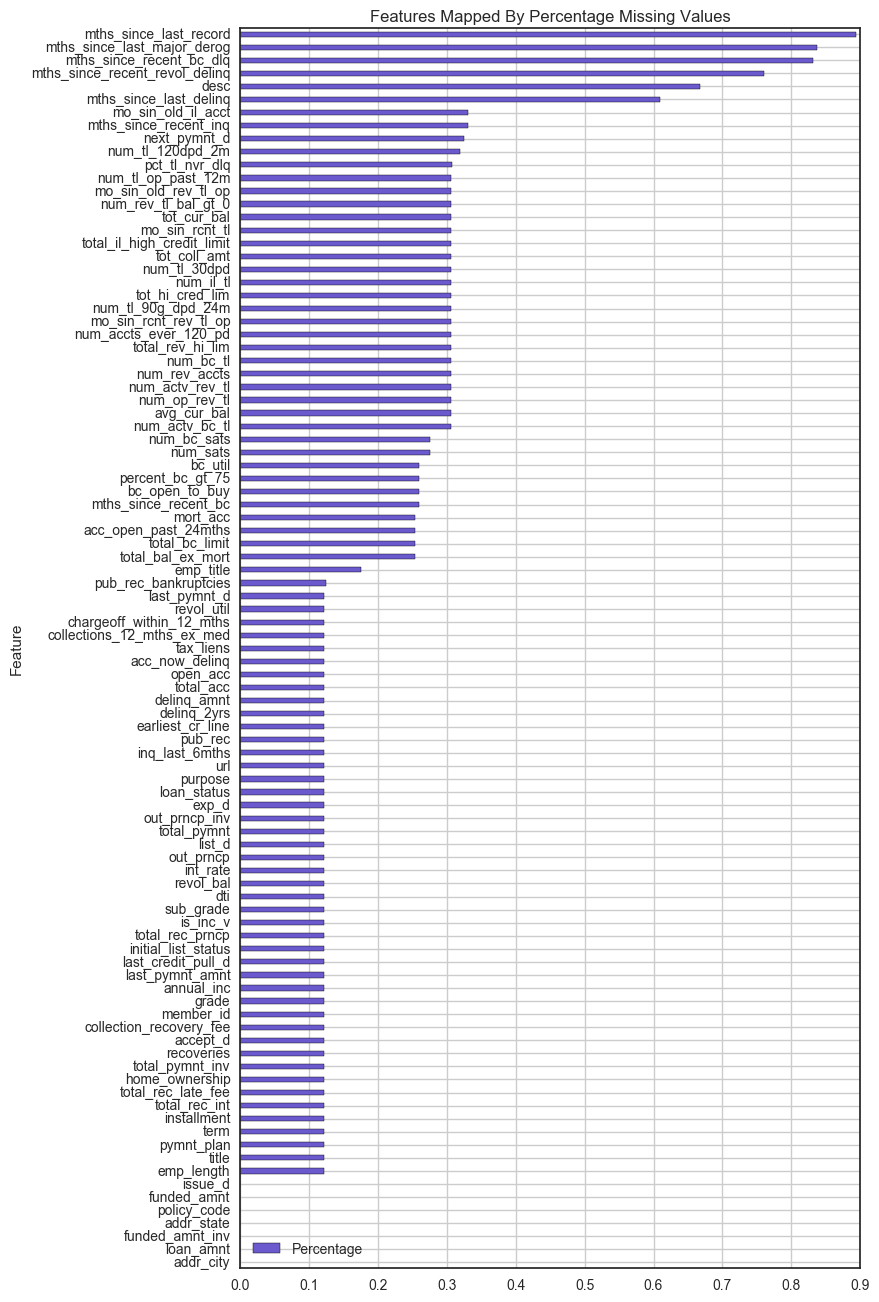

In [13]:
missing_df = find_missing_values(df)

cols = [x[0] for x in missing_df]
vals = [x[1] for x in missing_df]

pyplt.rcParams['figure.figsize'] = (8, 16)
percentage_nan_frame = pd.DataFrame({ 'Percentage': vals,'Feature': cols })
ax = percentage_nan_frame.plot(kind = 'barh',  width = 0.4, x = 'Feature', color = 'slateblue', 
                               title = "Features Mapped By Percentage Missing Values")
pyplt.grid(True)
pyplt.savefig('report/figures/missing_features.png', format='png', dpi=200)

# reset figure size
pyplt.rcParams['figure.figsize'] = (6, 4)

To make my analysis tractable given the time in which this analysis must be completed, I am going to restrict myself to features for which less than 20% are missing.

Am dropping `url`, `index`, `id`, `member_id`, `emp_title`, `title`

In [14]:
drop_list = ['url', 'index', 'id', 'member_id', 'emp_title', 'title']
for col, val in missing_df:
    if val > 0.2:
        drop_list.append(col)       

In [15]:
df.drop(drop_list, axis=1, inplace=True)

In [16]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,policy_code
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.00,0.00,2014-08-11,162.87,2014-08-21,0.0,0.0,0.0,0.0,1.0
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,117.08,1.11,2013-04-30,119.66,2013-09-23,0.0,0.0,0.0,0.0,1.0
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.00,0.00,2014-06-10,649.91,2014-08-21,0.0,0.0,0.0,0.0,1.0
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.00,0.00,2014-08-08,339.31,2014-08-21,0.0,0.0,0.0,0.0,1.0
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.00,0.00,2014-08-08,67.79,2014-08-21,0.0,0.0,0.0,0.0,1.0


Automatically detect column type

In [17]:
continuous_vars, rest = get_var_type(df)

### Categorical variable
- 'term',
-  'grade',
-  'sub_grade',
-  'emp_length',
-  'home_ownership',
-  'is_inc_v',
- 'loan_status',
- 'pymnt_plan',
- 'purpose',
- 'addr_city',
- 'addr_state',
- 'revol_util',
- 'initial_list_status',
 


### Dates
- 'accept_d',
-  'exp_d',
- 'list_d',
- 'issue_d',
- 'earliest_cr_line'
- 'last_pymnt_d',
- 'last_credit_pull_d'

In [18]:
display(df[continuous_vars[0:10]].head(1))
display(df[continuous_vars[10:20]].head(1))
display(df[continuous_vars[20:]].head(1))

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,acc_now_delinq,dti,delinq_2yrs,delinq_amnt,inq_last_6mths
0,5000.0,5000.0,4975.0,162.87,24000.0,0.0,27.65,0.0,0.0,1.0


,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int
0,3.0,0.0,13648.0,9.0,801.87,797.81,5037.97,5012.83,4198.13,839.84


,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,policy_code
0,0.0,0.0,0.0,162.87,0.0,0.0,0.0,0.0,1.0


### Data Preprocessing


In [19]:
get_item_description('revol_util')

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [20]:
df['int_rate'] = df['int_rate'].str.extract('(\d+.\d+)')
df['int_rate'] = df['int_rate'].map(lambda x: float(x))

In [21]:
df['revol_util'] = df['revol_util'].str.extract('(\d+.\d+)')
df['revol_util'] = df['revol_util'].map(lambda x: float(x))
df['revol_util'] = df['revol_util'].fillna(-1) # that is 25% missing, so filling with -1 to indicate missing

In [22]:
df.shape

(379058, 50)

In [23]:
df = df.dropna()
df.shape

(331476, 50)

In [24]:
categorical_var = ['term','grade','sub_grade',
 'emp_length','home_ownership','is_inc_v','pymnt_plan','purpose',
 'addr_city','addr_state','revol_util','initial_list_status']

date_var = ['accept_d','list_d','exp_d','issue_d',
'earliest_cr_line','last_pymnt_d','last_credit_pull_d']

#### Deal with dates

In [25]:
for cols in date_var:
    print (cols)
    df[cols+'_months'] = convert_date_months(df[cols])
    df[cols+'_days'] = convert_date_days(df[cols])

accept_d
list_d
exp_d
issue_d
earliest_cr_line
last_pymnt_d
last_credit_pull_d


#### Deal with categorical variables

In [26]:
display(df[categorical_var[0:10]].head(1))
display(df[categorical_var[10:]].head(1))

,term,grade,sub_grade,emp_length,home_ownership,is_inc_v,pymnt_plan,purpose,addr_city,addr_state
0,36 months,B,B2,10+ years,RENT,Verified,n,credit_card,FLAGSTAFF,AZ


,revol_util,initial_list_status
0,83.7,f


In [27]:
from sklearn.preprocessing import LabelEncoder


number = LabelEncoder()
df['term_old'] = df['term']  
df['term'] = number.fit_transform(df['term'].astype(str))


df['addr_city_old'] = df['addr_city']
df['addr_city'] = number.fit_transform(df['addr_city'].astype(str))

df['addr_state_old'] = df['addr_state']
df['addr_state'] = number.fit_transform(df['addr_state'].astype(str))

df['home_ownership_old'] = df['home_ownership']
df['home_ownership'] = number.fit_transform(df['home_ownership'].astype(str))

df['purpose_old'] = df['purpose']
df['purpose'] = number.fit_transform(df['purpose'].astype(str))

df['pymnt_plan_old'] = df['pymnt_plan']
df['pymnt_plan'] = number.fit_transform(df['pymnt_plan'].astype(str))

df['is_inc_v_old'] = df['is_inc_v']
df['is_inc_v'] = number.fit_transform(df['is_inc_v'].astype(str))

df['initial_list_status_old'] = df['initial_list_status']
df['initial_list_status'] = number.fit_transform(df['initial_list_status'].astype(str))


df['emp_length_old'] = df['emp_length']
df['emp_length'] = number.fit_transform(df['emp_length'].astype(str))

df['grade_old'] = df['grade']
df['grade'] = number.fit_transform(df['grade'].astype(str))

df['sub_grade_old'] = df['sub_grade']
df['sub_grade'] = number.fit_transform(df['sub_grade'].astype(str))

In [28]:
new_grade_var = [x for x in df.columns if 'grade' in x]
display(df[new_grade_var].head(1))

,grade,sub_grade,grade_old,sub_grade_old
0,1,6,B,B2


### Derive Features
1. `loan_rank`: 1 for bad loans, 0 for good loans  
    - **Good loans** are the ones where the status is 
        - current 
        - fully paid
    - **Bad loans** are the ones where the status is 
        - default
        - in grace period
        - late
        - charged off
2. Extract day of the week from dates
3. Extract week of the year from dates
 
 
#### Derive Features
- Loan Rank

In [29]:
data = df['loan_status']
data.dropna(inplace = True)

In [30]:
df['loan_status'].value_counts()

Current                                                        245953
Fully Paid                                                      62790
Charged Off                                                     13451
Late (31-120 days)                                               3876
In Grace Period                                                  2001
Does not meet the credit policy.  Status:Fully Paid              1444
Late (16-30 days)                                                 981
Does not meet the credit policy.  Status:Charged Off              523
Default                                                           356
Does not meet the credit policy.  Status:Current                   92
Does not meet the credit policy.  Status:Late (31-120 days)         6
Does not meet the credit policy.  Status:In Grace Period            1
Does not meet the credit policy.  Status:Late (16-30 days)          1
Does not meet the credit policy.  Status:Default                    1
Name: loan_status, d

In [31]:
index_ = df['loan_status'][df['loan_status'].str.contains('(Does not meet the credit*)')].index

I did some research and discovered that loans with the prefix "Does not meet the credit.." in `loan_status`, are past loans that were granted before Lending Club did a major change to their lending policy. These represent less than 1% of all loans in the dataset. Moving forward, I will discard these loans from my analysis.

In [32]:
df.ix[index_, 'loan_status'].count() / len(df) * 100

0.62387623840036688

In [33]:
df.drop(df.index[index_], inplace=True)

In [34]:
# Create a set of dummy variables from the 'loan_status' variable
df_loan_status = pd.get_dummies(df['loan_status'])

In [35]:
df['loan_rank'] =  df_loan_status[u'Default'] +  df_loan_status[u'In Grace Period'] + \
                   df_loan_status[u'Late (16-30 days)'] + df_loan_status[ u'Late (31-120 days)'] + \
                   df_loan_status[u'Charged Off']
    
df.drop(['loan_status'], axis = 1, inplace = True)

#### Derive Features
- Extract day of the week from dates
- Extract week of the year from dates

In [36]:
for cols in date_var:
    print (cols)
    df[cols+'_num_day'] = df[cols].apply(lambda x: convert_num_day_of_week(x)) 
    df[cols+'_day'] = df[cols].apply(lambda x: convert_day_of_week(x))
    df[cols+'_week_of_year'] = df[cols].apply(lambda x: convert_week_of_year(x)) 

accept_d
list_d
exp_d
issue_d
earliest_cr_line
last_pymnt_d
last_credit_pull_d


### Save Dataset to file

In [37]:
joblib.dump(df, dataPath+'/df_cleaned.pkl')

['data/df_cleaned.pkl']